<a href="https://colab.research.google.com/github/mumin7410/Titanic-Prediction/blob/master/Cats%26Dogs_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os 
import cv2
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_file = "/content/drive/My Drive/Colab Notebooks/dog cat/train.zip"
test_file = "/content/drive/My Drive/Colab Notebooks/dog cat/test1.zip"

In [ ]:
import zipfile

with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()
with zipfile.ZipFile(test_file, 'r') as z:
    z.extractall()

In [ ]:
import os
import cv2

def load_image(file_path):
    return cv2.imread(file_path)        #อ่านค่ารูปภาพจากที่อยู่ไฟล์

def extract_label(file_name):
    return 1 if "dog" in file_name else 0          #ให้ค่า 1 ถ้าชื่อไฟล์เป็น Dog

train_path = "./train/" #กำหนดที่อยู่โฟลเดอร์
image_files = os.listdir(train_path) #ให้ image_files = ที่อยู่ของโฟลเดอร์รูป
train_images = [load_image(train_path + file) for file in image_files] #ทำการโหลดรูปภาพจากการโฟลเดอร์ + ไฟล์ โดยที่ไฟล์อยู่ในโฟลเดอร์
train_labels = [extract_label(file) for file in image_files] #ทำการแตกไฟล์รูปให้เป็น label จากโฟลเดอร์

In [ ]:
def preprocess_image(img, side=96):
    min_side = min(img.shape[0], img.shape[1])
    img = img[:min_side, :min_side]
    img = cv2.resize(img, (side,side))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img / 255.0

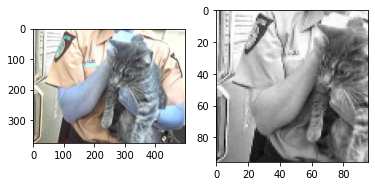

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

preview_index = 21000
plt.subplot(1,2,1)
plt.imshow(train_images[preview_index])
plt.subplot(1,2,2)
plt.imshow(preprocess_image(train_images[preview_index]), cmap="gray")

In [ ]:
for i in range(len(train_images)):
    train_images[i] = preprocess_image(train_images[i])

In [ ]:
import numpy as np

train_images = np.expand_dims(train_images, axis=-1)
train_labels = np.array(train_labels)
print(train_images.shape, train_labels.shape)

(25000, 96, 96, 1) (25000,)


In [ ]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

layers = [
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(layers)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=5, batch_size=50)
model.save_weights("model.tf")

Tensorflow: 2.3.0
Epoch 1/5
500/500 [==============================] - 5s 10ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.6321
Epoch 2/5
500/500 [==============================] - 5s 10ms/step - loss: 0.4698 - sparse_categorical_accuracy: 0.7748
Epoch 3/5
500/500 [==============================] - 5s 10ms/step - loss: 0.3670 - sparse_categorical_accuracy: 0.8379
Epoch 4/5
500/500 [==============================] - 5s 10ms/step - loss: 0.2994 - sparse_categorical_accuracy: 0.8694
Epoch 5/5
500/500 [==============================] - 5s 10ms/step - loss: 0.2544 - sparse_categorical_accuracy: 0.8914


In [ ]:
from google.colab import files
uploads = files.upload()

In [ ]:
eval_images = [preprocess_image(load_image(file)) for file in uploads.keys()]
eval_model = tf.keras.Sequential(layers)
eval_model.load_weights("model.tf")
eval_predictions = eval_model.predict(np.expand_dims(eval_images, axis=-1))

cols = 4
rows = np.ceil(len(eval_images)/cols)
fig = plt.gcf()
fig.set_size_inches(cols * 2, rows * 2)
for i in range(len(eval_images)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(eval_images[i], cmap="gray")
    plt.title("Dog" if np.argmax(eval_predictions[i])==1 else "Cat")
    plt.axis('off')